<font size = "5"> **[Image Tools](2_Image_Tools.ipynb)** </font>

<hr style="height:2px;border-top:4px solid #FF8200" />


# Adaptive Fourier Filtering


part of 

<font size = "4"> **pyTEMlib**, a **pycroscopy** library </font>


Notebook by 

Gerd Duscher

Materials Science & Engineering<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville


An introduction into Fourier Filtering of images.


## Install pyTEMlib

If you have not done so in the [Introduction Notebook](_.ipynb), please test and install [pyTEMlib](https://github.com/gduscher/pyTEMlib) and other important packages with the code cell below.


In [1]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = (get_distribution(package_name).version)
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

# Colab setup ------------------
if 'google.colab' in sys.modules:
    !pip install git+https://github.com/pycroscopy/pyTEMlib/ -q

# pyTEMlib setup ------------------
else:
    if test_package('sidpy') < '0.0.7':
        print('installing sidpy')
        !{sys.executable} -m pip install  --upgrade sidpy -q     
    if test_package('pyNSID') < '0.0.3':
        print('installing pyNSID')
        !{sys.executable} -m pip install  --upgrade pyNSID -q 
    if test_package('pyTEMlib') < '0.2022.10.1':
        print('installing pyTEMlib')
        !{sys.executable} -m pip install  --upgrade pyTEMlib -q
# ------------------------------
print('done')

installing sidpy
installing pyTEMlib
done


## Loading of necessary libraries

Please note, that we only need to load the pyTEMlib library, which is based on sidpy Datsets. 



In [1]:
%pylab  notebook

import pyTEMlib
import pyTEMlib.file_tools as ft
import pyTEMlib.image_tools as it

print('pyTEMlib version: ', pyTEMlib.__version__)
note_book_version = '2021.10.22'
note_book_name='pyTEMib/notebooks/Imaging/Adaptive_Fourier_Filter'

Populating the interactive namespace from numpy and matplotlib
pyTEMlib version:  0.2021.10.1


## Open File

These datasets are stored in the pyNSID data format (extension: hf5) automatically. 

All results can be stored in that file. 

First we select the file

In [2]:
file_widget = ft.FileWidget()

Select(description='Select file:', layout=Layout(width='70%'), options=('.',), rows=10, value='.')

Now, we open and plot them

Cannot overwrite file. Using:  Recording of SuperScan (MAADForABF)-7.hf5
We really would need an image here


C:\Users\gdusc\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:350: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


<IPython.core.display.Javascript object>


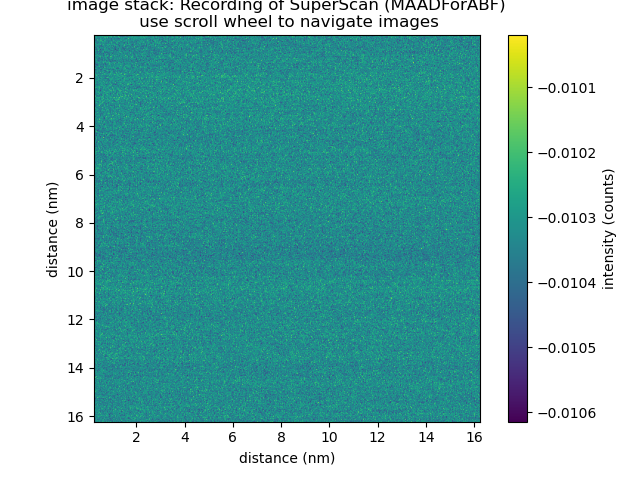

In [9]:
file_name = file_widget.file_name
try:
    dataset.h5_dataset.file.close()
except:
    pass
dataset= ft.open_file(file_name)
if dataset.data_type.name != 'IMAGE':
    print('We really would need an image here')

dataset.plot()

In [ ]:
file_widget = ft.FileWidget()

<IPython.core.display.Javascript object>


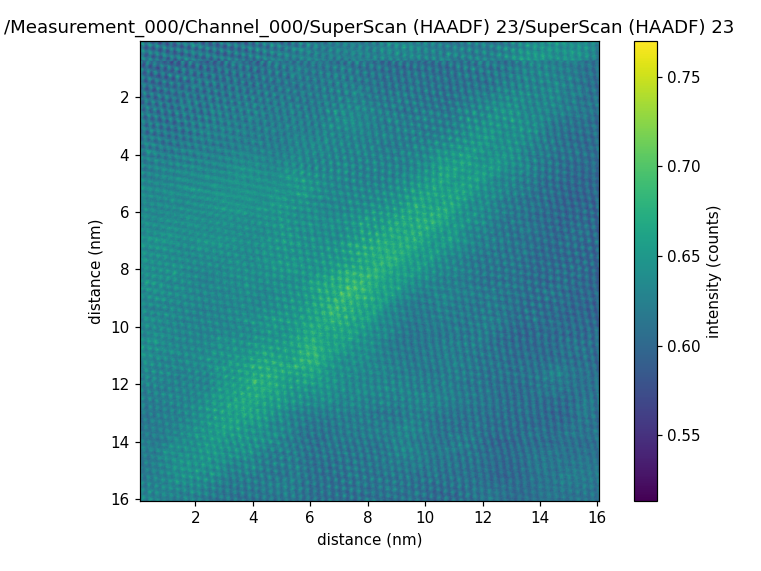

In [22]:
dataset.plot()

In [18]:
dataset.view_original_metadata()

original_metadata :
	category : persistent
	collection_dimension_count : 0
	created : 2021-08-04T19:19:00.713522
	data_dtype : float32
	data_modified : 2021-08-04T19:19:00.723519
	data_shape : [2048 2048]
	datum_dimension_count : 2
	dim-offset-0 : -8.0
	dim-offset-1 : -8.0
	dim-scale-0 : 0.0078125
	dim-scale-1 : 0.0078125
	dim-units-0 : nm
	dim-units-1 : nm
	intensity_calibration-offset : 0.0
	intensity_calibration-scale : 1.0
	intensity_calibration-units : 
	is_sequence : False
	metadata-hardware_source-ac_line_sync : 1
	metadata-hardware_source-autostem-ImageScanned:BP1.^VOACurrent : 4.34736e-09
	metadata-hardware_source-autostem-ImageScanned:C1 ConstW : 0.338
	metadata-hardware_source-autostem-ImageScanned:C10 : -2.43353e-08
	metadata-hardware_source-autostem-ImageScanned:C12.a : 1.90952e-09
	metadata-hardware_source-autostem-ImageScanned:C12.b : 9.88033e-09
	metadata-hardware_source-autostem-ImageScanned:C21.a : 2.12776e-08
	metadata-hardware_source-autostem-ImageScanned:C21.b : -1

Check dataset

In [ ]:
print(dataset)
dataset

In [ ]:
ft.h5_tree(dataset.h5_dataset)
# dataset.h5_dataset.file.close()

If there are more than one dataset in file, choose one

In [24]:
choose_image = ft.ChooseDataset(dataset.h5_dataset.parent)

C:\Users\gdusc\anaconda3\lib\site-packages\pyNSID\io\nsi_reader.py:41: FutureWarning: This Reader will be moved to the ScifiReaders package in next release.. Be prepared to change your import statements
  warn('This Reader will be moved to the ScifiReaders package in next release.'
C:\Users\gdusc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Dropdown(description='select dataset:', options=('SuperScan (HAADF) 23',), value='SuperScan (HAADF) 23')

## Fourier Transform of Image

Shape of dataset is:  (2048, 2048)
2D dataset


<IPython.core.display.Javascript object>


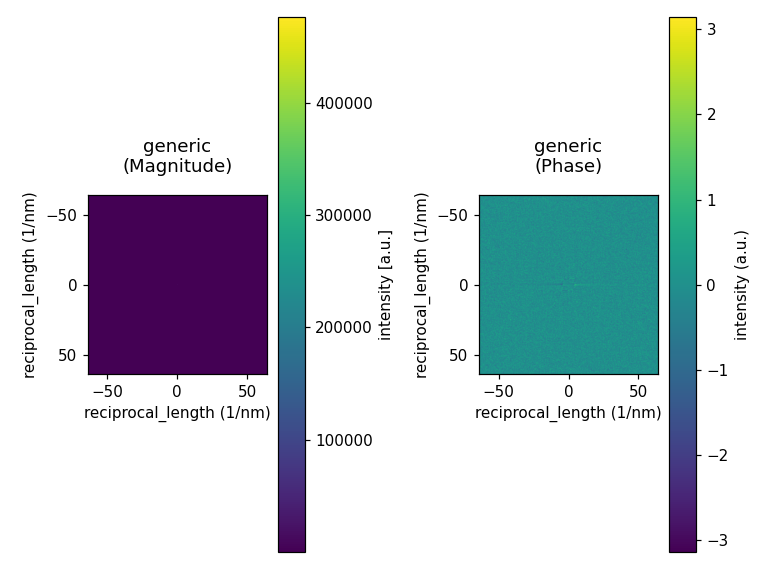

In [25]:
fft_dataset = it.fourier_transform(choose_image.dataset)
fft_dataset.view_metadata()
kwargs = {'figsize':(10,5)}
fft_dataset.plot(kwargs)

## Power Spectrum of Image

fft :
	smoothing : 1
	minimum_intensity : 2.757695016541735
	maximum_intensity : 9.058156862753593
source:  NionReader


<IPython.core.display.Javascript object>


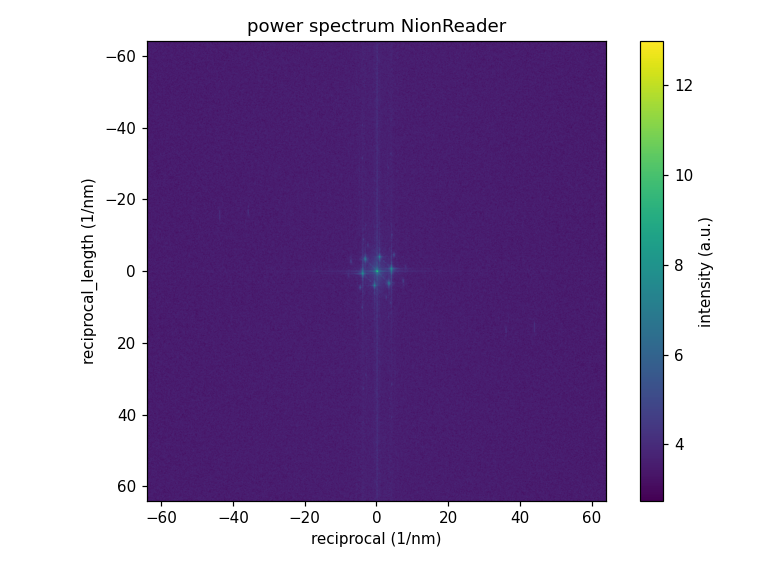

In [26]:
power_spectrum = it.power_spectrum(choose_image.dataset, smoothing=1)

power_spectrum.view_metadata()
print('source: ', power_spectrum.source)
power_spectrum.plot()

## Spot Detection in Fourier Transform

Found 3 reflections


<IPython.core.display.Javascript object>


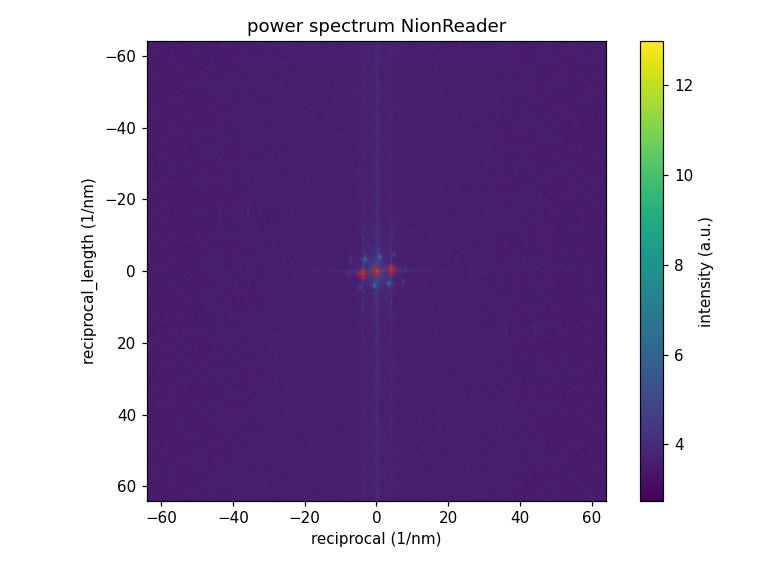

In [34]:
# ------Input----------
spot_threshold=0.16
# ---------------------
spots = it.diffractogram_spots(power_spectrum, spot_threshold=spot_threshold)
power_spectrum.plot()
plt.gca().scatter(spots[:,0],spots[:,1], color='red', alpha=0.4);

## Adaptive Fourier Filter

<IPython.core.display.Javascript object>


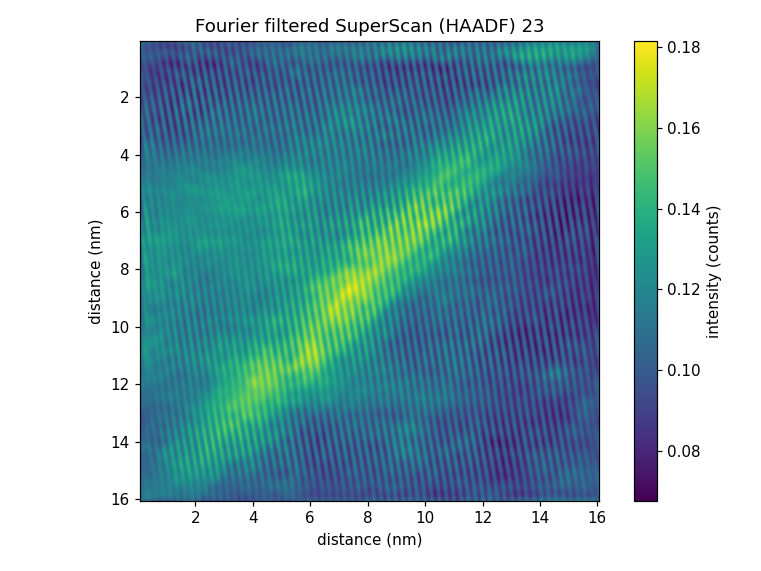

In [35]:
filtered_dataset = it.adaptive_fourier_filter(choose_image.dataset, spots, low_pass=2., reflection_radius=.3)
filtered_dataset.plot()

Let's see what we did - In Fourier space, of course.

<IPython.core.display.Javascript object>


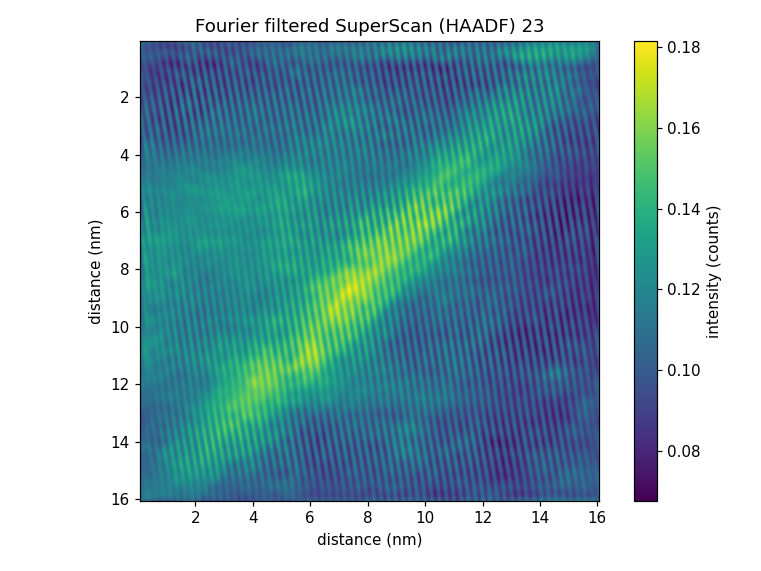

In [39]:
filtered_dataset.view.fig

In [ ]:
filtered_power_spectrum = it.power_spectrum(filtered_dataset, smoothing=0)

power_spectrum.view_metadata()
print('source: ', power_spectrum.source)
filtered_power_spectrum.plot()

Please note that the spots are ordered from center to outside.

The third parameter of a spot is its angle.

In [ ]:
print(spots[:5])

## Log the result

In [ ]:
results_channel = ft.log_results(dataset.h5_dataset.parent.parent, filtered_dataset)


A tree-like plot of the file

In [ ]:
ft.h5_tree(dataset.h5_dataset.file)

In [ ]:
dataset.h5_dataset.parent

A convenient function to select a dataset (for further processing, visualization or whatever)

In [ ]:
choose_image = ft.ChooseDataset(dataset.h5_dataset.parent.parent)

The selected dataset can then easily be plotted

In [ ]:
choose_image.dataset.plot()

## Close File
let's close the file but keep the filename

In [ ]:
filename = results_channel.file.filename
results_channel.file.close()

## Simulate new notebook
We can now simulate a new notebook and open the file again.



In [ ]:
new_dataset= ft.open_file(filename)
choose_image = ft.ChooseDataset(new_dataset.h5_dataset.parent)

In [ ]:
choose_image.dataset.plot()

We want to make an image operation of the images in the file.

In [ ]:
choose_image = ft.ChooseDataset(new_dataset.h5_dataset.parent.parent)
print('       subtract')
choose_image2 = ft.ChooseDataset(new_dataset.h5_dataset.parent)

In [ ]:
new_image = np.array(choose_image.dataset) - np.array(choose_image2.dataset)
new_image = new_dataset.like_data(new_image)
new_image.plot()

## Close File for Good

In [ ]:
new_dataset.h5_dataset.file.close()